In [52]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

#Read the data file
f = h5py.File('data.h5', 'r')

#The images are of shape 20*20
#Each row in X and testX represents an image
#Reshape both arrays, so they are 3D and represents multiple images in 2D format
xTrain = np.reshape(f['X'], (-1, 20, 20))
xTest = np.reshape(f['testX'], (-1, 20, 20))

yTrain = f['y']
yTest = f['testy']

In [53]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from datetime import datetime

In [54]:
#Convert 2D greyscale images into 3D images, so they are compatible with tensorflow
xTrain = np.reshape(xTrain,(xTrain.shape[0],xTrain.shape[1],xTrain.shape[2],1))
xTest = np.reshape(xTest,(xTest.shape[0],xTest.shape[1],xTest.shape[2],1))

xTrain.shape

(439452, 20, 20, 1)

In [55]:
yTrain = tf.keras.utils.to_categorical(yTrain,2)
yTest = tf.keras.utils.to_categorical(yTest,2)

In [56]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from datetime import datetime

In [57]:
#Pre processing the data

#This generator will generate all the images when needed. It will normalise the data (mean - 0, std - 1). It also splits the data into train-validation sets. The validation set size is 20%. This validation set is used for training the neural network and updating weights and biases. 

datagen = ImageDataGenerator(
    rescale=1./255, 
    featurewise_center=True, 
    featurewise_std_normalization=True,
    validation_split=0.2 
    )


batchSize = 36 # no. of samples to be used in each iteration of training the network

datagen.fit(xTrain) #Compute and apply mean/stf normalisation

In [58]:
#Set up training and test data batches

#Set up the training data set
train_generator = datagen.flow(
    xTrain, 
    yTrain, 
    batch_size=batchSize, 
    shuffle=True, 
    subset='training' #since validation set defined above was 20%, this generator takes 80% of the training data
                      
    )

#Set up the validation set
val_generator = datagen.flow(
    xTrain,
    yTrain,
    batch_size=batchSize,
    shuffle=True,
    subset='validation'
    )

#Set up the test set
test_generator =  datagen.flow(
    xTest,
    yTest,
    batch_size=1 #Only test 1 sample at a time
    )

In [59]:
#Set up model 

model = tf.keras.Sequential() #Create feedforward network

model.add(tf.keras.layers.Flatten()) #Flatten our input layer into a single column tensor

#Add three hidden layers
#Our input has 20x20 = 400 points
#Output has 2 points
#The number of neurons should descend throughout the network and stay in between these values

model.add(tf.keras.layers.Dense(200, activation="relu"))
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(50, activation="relu"))

#Output layer, return the probability of each output response and pick the highest one (softmax)
model.add(tf.keras.layers.Dense(2, activation='softmax'))    

In [60]:
#During training, in each iteration of updating the weights, the validation set is used to calculate the accuracy (no of correct predictions) and loss (difference between correct and predicted values)
#Accuracy should increase, loss should decrease

#During training, if the accuracy increases, save the weights to a local file
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "FeedForwardModel.h5", 
    monitor = "val_accuracy", 
    verbose = 1, 
    save_best_only = True,
    mode = 'max'
    )

#During training, if the loss stops decreasing, stop training.
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=5, 
    verbose=1, 
    mode='min', 
    baseline=None, 
    restore_best_weights=False 
)

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler= tf.keras.callbacks.LearningRateScheduler(scheduler)

logdir = "../logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# collecting all callbacks together
callbacks_list = [checkpoint, earlystopping, lr_scheduler, tensorboard_callback]

In [61]:
#Evaluate the model

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 10
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batchSize,
    validation_data=val_generator,
    validation_steps=val_generator.n // batchSize,
    epochs=EPOCHS,
    callbacks=callbacks_list
    )

Epoch 1/10
9734/9765 [============================>.] - ETA: 0s - loss: 0.1734 - accuracy: 0.9276
Epoch 1: val_accuracy improved from -inf to 0.95681, saving model to model.h5
9765/9765 [==============================] - 21s 2ms/step - loss: 0.1731 - accuracy: 0.9277 - val_loss: 0.1120 - val_accuracy: 0.9568 - lr: 1.0000e-04
Epoch 2/10
9758/9765 [============================>.] - ETA: 0s - loss: 0.0851 - accuracy: 0.9685
Epoch 2: val_accuracy improved from 0.95681 to 0.96478, saving model to model.h5
9765/9765 [==============================] - 23s 2ms/step - loss: 0.0850 - accuracy: 0.9685 - val_loss: 0.0956 - val_accuracy: 0.9648 - lr: 1.0000e-04
Epoch 3/10
9761/9765 [============================>.] - ETA: 0s - loss: 0.0632 - accuracy: 0.9778
Epoch 3: val_accuracy improved from 0.96478 to 0.96790, saving model to model.h5
9765/9765 [==============================] - 22s 2ms/step - loss: 0.0632 - accuracy: 0.9778 - val_loss: 0.0887 - val_accuracy: 0.9679 - lr: 1.0000e-04
Epoch 4/10
97

In [62]:
# load weights
model.load_weights("FeedForwardModel.h5")  #The last set of weights saved should be the one with the best accuracy, so we used this set

test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}, test loss: {test_loss}')

146484/146484 [==============================] - 87s 593us/step - loss: 0.0900 - accuracy: 0.9685
Test accuracy: 0.9684743881225586, test loss: 0.08996257930994034


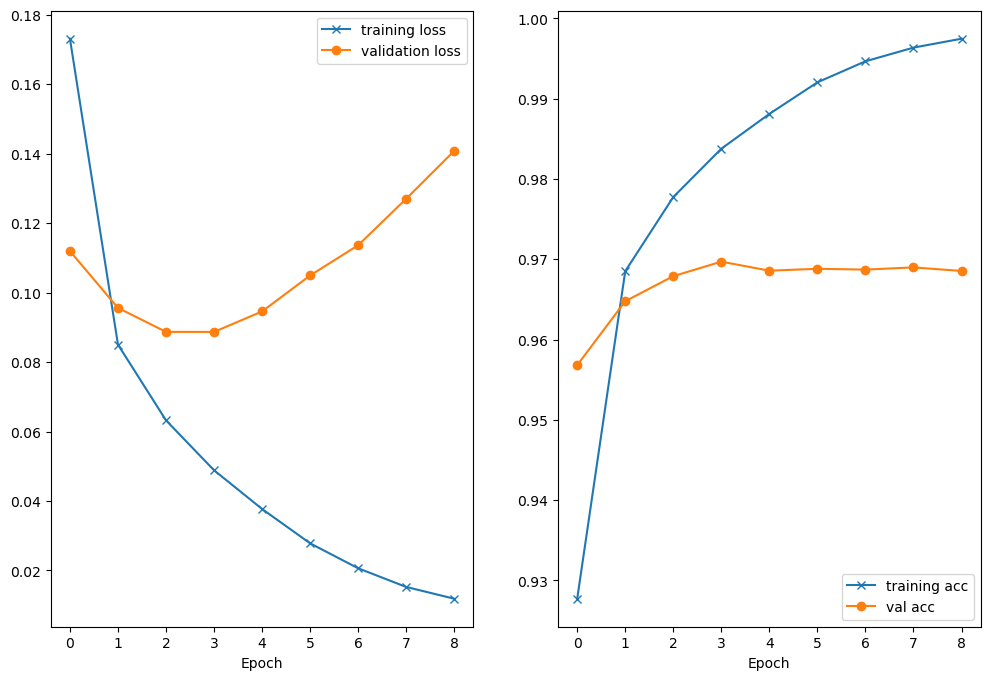

In [64]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'x-', label="training loss", )
plt.plot(history.history['val_loss'], 'o-', label="validation loss")
plt.legend(loc='upper right')
plt.xlabel("Epoch")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'x-', label="training acc")
plt.plot(history.history['val_accuracy'], 'o-', label="val acc")
plt.legend(loc='lower right')
plt.xlabel("Epoch")
plt.show()

In [ ]:
#Overfitting starts at epoch 3
#Move to CNN 